In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

#### Define the ODE system: S, I, Q, R, V

In [2]:
def isolation_vaccination_odes(t, y, beta, gamma, delta, epsilon, nu):
    """
    y = [S, I, Q, R, V]
    dS/dt = -beta*S*I/N - nu*S
    dI/dt =  beta*S*I/N - gamma*I - delta*I
    dQ/dt =  delta*I - epsilon*Q
    dR/dt =  gamma*I + epsilon*Q
    dV/dt =  nu*S
    """
    S, I, Q, R, V = y
    N = S + I + Q + R + V

    # New infections per unit time
    new_infections = beta * S * I / N
    # Isolation flow
    isolation_flow = delta * I
    # Vaccination flow
    vac_flow = nu * S
    # Recoveries from I
    rec_I = gamma * I
    # Recoveries from Q
    rec_Q = epsilon * Q

    dSdt = -new_infections - vac_flow
    dIdt = new_infections - rec_I - isolation_flow
    dQdt = isolation_flow - rec_Q
    dRdt = rec_I + rec_Q
    dVdt = vac_flow

    return [dSdt, dIdt, dQdt, dRdt, dVdt]


#### 2) Set parameter values and initial conditions

In [3]:
# Total population (constant)
N0 = 1_000_000

# Initial compartment sizes
I0 = 1        #  1 initial infected
S0 = N0 - I0  #  the rest are susceptible
Q0 = 0        #  no one is isolated at t=0
R0 = 0        #  no one recovered initially
V0 = 0        #  no one vaccinated initially

y0 = [S0, I0, Q0, R0, V0]

# Model parameters (you can tweak these):
beta    = 0.3      # Infection rate (per contact)  
gamma   = 1/14     # Recovery rate from I   (mean infectious period ≈ 14 days)  
delta   = 0.05     # Isolation rate (per day)  
epsilon = 1/10     # Recovery rate from Q  (mean isolation period ≈ 10 days)  
nu      = 1e-3     # Vaccination rate (per susceptible per day)

# Time span (days) and evaluation points
t_start = 0
t_end   = 160
t_eval  = np.linspace(t_start, t_end, 801)  # 801 points => step ~0.2 day


#### 3) Integrate the ODE system with solve_ivp


In [12]:
sol = solve_ivp(
    fun=lambda t, y: isolation_vaccination_odes(t, y, beta, gamma, delta, epsilon, nu),
    t_span=(t_start, t_end),
    y0=y0,
    t_eval=t_eval,
    vectorized=False,
    rtol=1e-6,
    atol=1e-8
)

# Unpack solution arrays
S = sol.y[0]
I = sol.y[1]
Q = sol.y[2]
R = sol.y[3]
V = sol.y[4]
t = sol.t
N = S + I + Q + R + V  # numerically should be constant = N0


#### 4) Plot the time series of each compartment


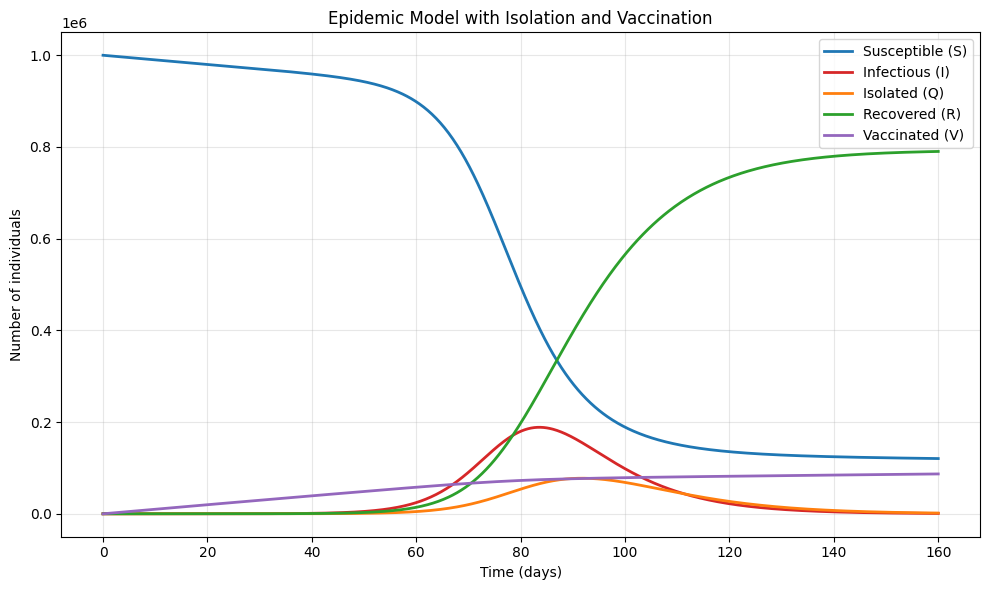

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible (S)',     color='tab:blue', linewidth=2)
plt.plot(t, I, label='Infectious (I)',      color='tab:red',  linewidth=2)
plt.plot(t, Q, label='Isolated (Q)',         color='tab:orange', linewidth=2)
plt.plot(t, R, label='Recovered (R)',       color='tab:green', linewidth=2)
plt.plot(t, V, label='Vaccinated (V)',      color='tab:purple', linewidth=2)

plt.xlabel("Time (days)")
plt.ylabel("Number of individuals")
plt.title("Epidemic Model with Isolation and Vaccination")
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### 5) Compute and plot additional metrics (e.g. daily incidence)

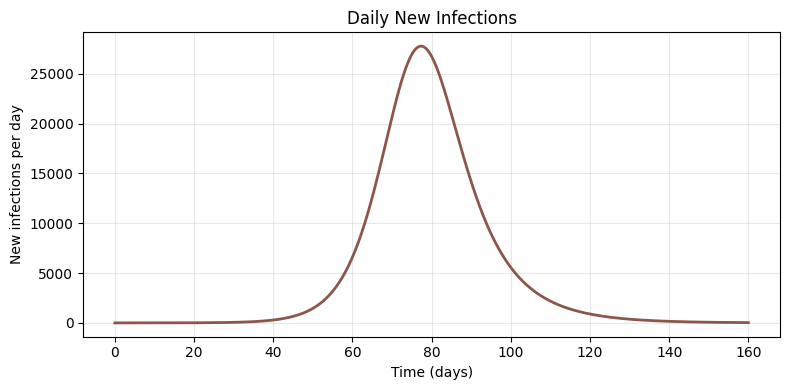

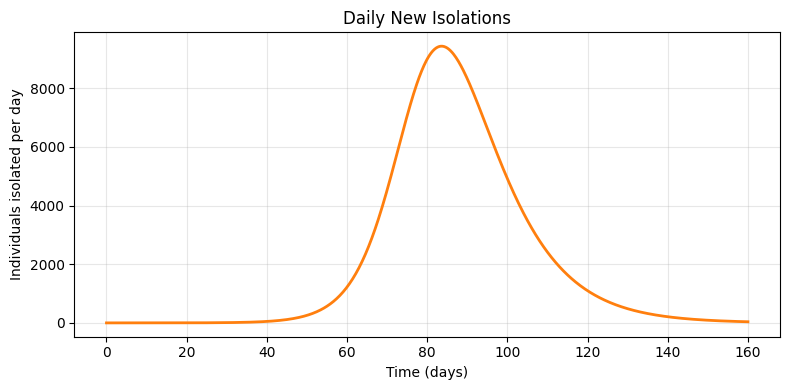

In [6]:
# Daily new infections = beta*S*I/N evaluated at each t
daily_new_infections = beta * S * I / (S + I + Q + R + V)

plt.figure(figsize=(8, 4))
plt.plot(t, daily_new_infections, color='tab:brown', linewidth=2)
plt.xlabel("Time (days)")
plt.ylabel("New infections per day")
plt.title("Daily New Infections")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Daily isolations = delta * I(t)
daily_isolations = delta * I

plt.figure(figsize=(8, 4))
plt.plot(t, daily_isolations, color='tab:orange', linewidth=2)
plt.xlabel("Time (days)")
plt.ylabel("Individuals isolated per day")
plt.title("Daily New Isolations")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### 6) Additional Dynamical Graphs


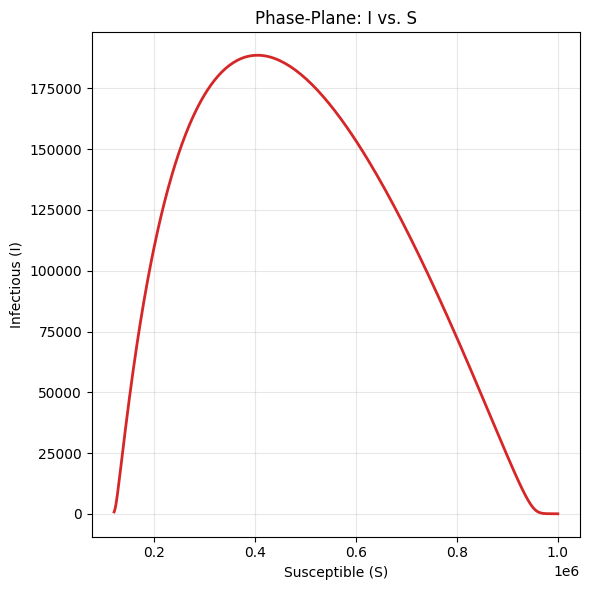

In [8]:
#6a) Phase‐Plane Plot: I vs. S
plt.figure(figsize=(6, 6))
plt.plot(S, I, 'tab:red', lw=2)
plt.xlabel("Susceptible (S)")
plt.ylabel("Infectious (I)")
plt.title("Phase‐Plane: I vs. S")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

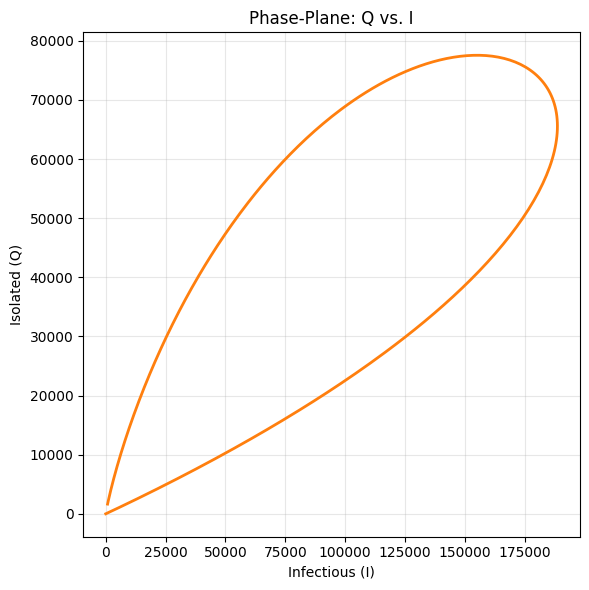

In [9]:
# 6b) Phase‐Plane Plot: Q vs. I
plt.figure(figsize=(6, 6))
plt.plot(I, Q, 'tab:orange', lw=2)
plt.xlabel("Infectious (I)")
plt.ylabel("Isolated (Q)")
plt.title("Phase‐Plane: Q vs. I")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

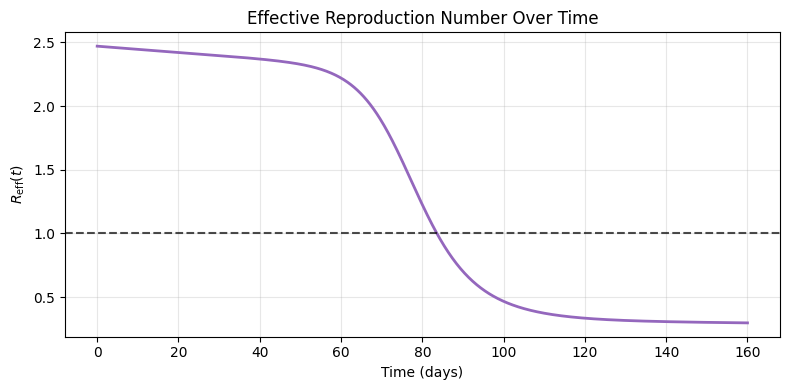

In [13]:
# 6c) Effective Reproduction Number R_eff(t) = (beta*S/N) / (gamma + delta)
R_eff = (beta * S / N) / (gamma + delta)
plt.figure(figsize=(8, 4))
plt.plot(t, R_eff, 'tab:purple', lw=2)
plt.axhline(1.0, color='k', linestyle='--', alpha=0.7)
plt.xlabel("Time (days)")
plt.ylabel(r"$R_{\mathrm{eff}}(t)$")
plt.title("Effective Reproduction Number Over Time")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

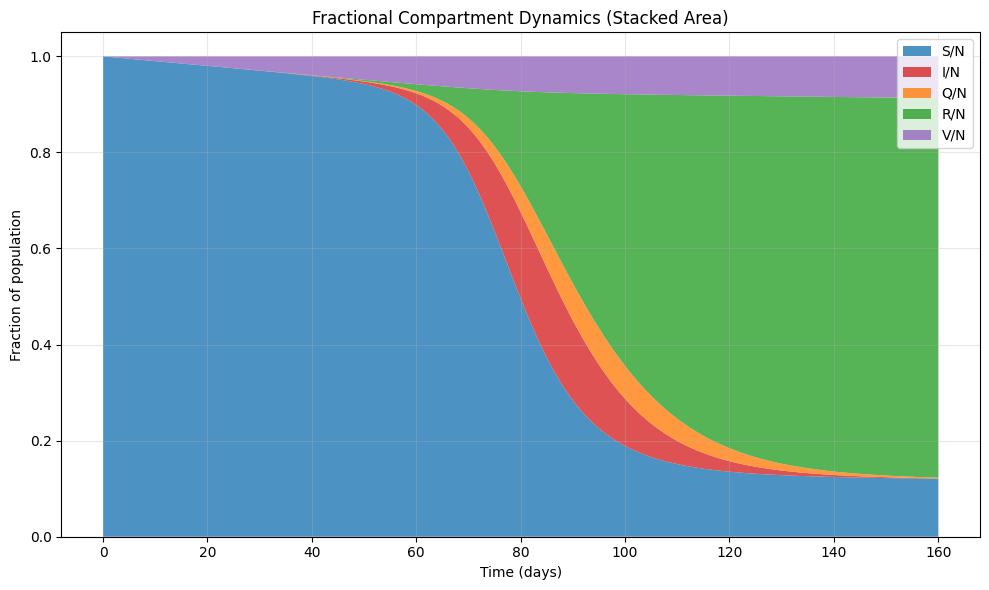

In [14]:
# 6d) Stacked‐Area Plot of Fractions [S, I, Q, R, V]
frac_S = S / N
frac_I = I / N
frac_Q = Q / N
frac_R = R / N
frac_V = V / N

plt.figure(figsize=(10, 6))
plt.stackplot(
    t,
    frac_S, frac_I, frac_Q, frac_R, frac_V,
    labels=['S/N', 'I/N', 'Q/N', 'R/N', 'V/N'],
    colors=['tab:blue', 'tab:red', 'tab:orange', 'tab:green', 'tab:purple'],
    alpha=0.8
)
plt.xlabel("Time (days)")
plt.ylabel("Fraction of population")
plt.title("Fractional Compartment Dynamics (Stacked Area)")
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

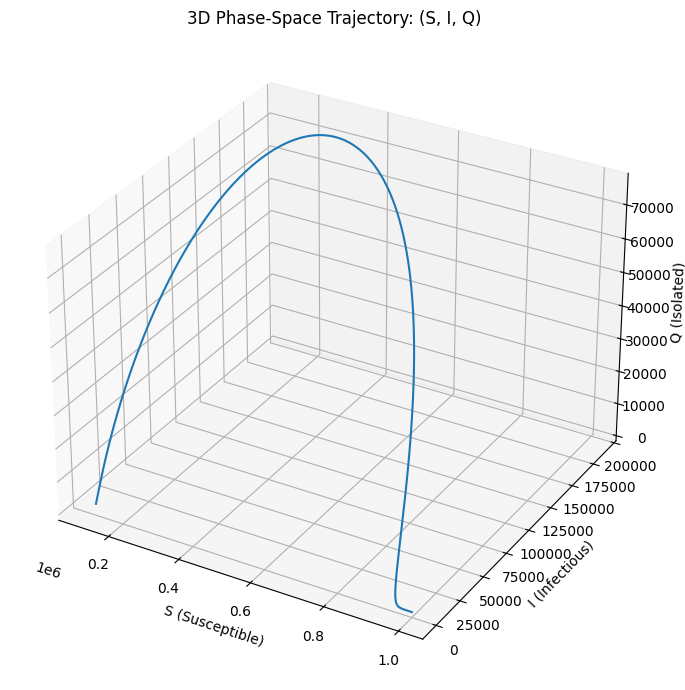

In [15]:
# 6e) 3D Trajectory in (S, I, Q)‐space
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(S, I, Q, color='tab:blue', lw=1.5)
ax.set_xlabel("S (Susceptible)")
ax.set_ylabel("I (Infectious)")
ax.set_zlabel("Q (Isolated)")
ax.set_title("3D Phase‐Space Trajectory: (S, I, Q)")
plt.tight_layout()
plt.show()

#### 7) Print Final Values and Basic Summary


In [16]:
print(f"Final values at t = {t_end} days:")
print(f"  Susceptible (S) : {S[-1]:.0f}")
print(f"  Infectious (I)  : {I[-1]:.0f}")
print(f"  Isolated (Q)    : {Q[-1]:.0f}")
print(f"  Recovered (R)   : {R[-1]:.0f}")
print(f"  Vaccinated (V)  : {V[-1]:.0f}")

Final values at t = 160 days:
  Susceptible (S) : 120472
  Infectious (I)  : 768
  Isolated (Q)    : 1639
  Recovered (R)   : 790211
  Vaccinated (V)  : 86910
